In [3]:
!pip install -U efficientnet==0.0.4
!pip install keras-rectified-adam
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-s_if8eex
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-s_if8eex
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.0-cp36-none-any.whl size=42211 sha256=11c51ad7808360ace7fe2070a60ba2044418fcb7bf275b637de439427c7a115e
  Stored in directory: /tmp/pip-ephem-wheel-cache-icwm6nhc/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [4]:
import os
import seaborn as sns
import pydicom
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from os.path import join
from PIL import Image
import tensorflow as tf
from efficientnet import EfficientNetB4
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras_radam import RAdam
from keras_preprocessing.image import ImageDataGenerator
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
os.listdir('/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection')

['stage_2_sample_submission.csv',
 'stage_2_train.csv',
 'stage_2_test',
 'stage_2_train']

In [6]:
root_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
train_image_dir = 'stage_2_train/'
test_image_dir = 'stage_2_test/'
train_csv_file = 'stage_2_train.csv' 
test_csv_file = 'stage_2_sample_submission.csv'

train_csv_data = pd.read_csv(root_path + train_csv_file)
train_csv_data

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
...,...,...
4516837,ID_4a85a3a3f_intraparenchymal,0
4516838,ID_4a85a3a3f_intraventricular,0
4516839,ID_4a85a3a3f_subarachnoid,0
4516840,ID_4a85a3a3f_subdural,0


In [7]:
test_csv_data = pd.read_csv(root_path + test_csv_file)

train_csv_data['img_file'] = train_csv_data['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
train_csv_data['subtype'] = train_csv_data['ID'].apply(lambda st: st.split('_')[2])
test_csv_data['img_file'] = test_csv_data['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
test_csv_data['subtype'] = test_csv_data['ID'].apply(lambda st: st.split('_')[2])

print(train_csv_data.shape)
train_csv_data.head()

(4516842, 4)


,ID,Label,img_file,subtype
0,ID_12cadc6af_epidural,0,ID_12cadc6af.png,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af.png,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af.png,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af.png,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af.png,subdural


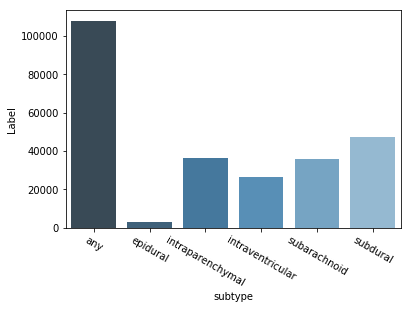

In [8]:
groupSub = train_csv_data.groupby('subtype').sum()
label_subtype_plot = sns.barplot(y=groupSub.Label, x=groupSub.index, palette="Blues_d")

for item in label_subtype_plot.get_xticklabels():
    item.set_rotation(-30)

In [9]:
unique_test_img = pd.DataFrame(test_csv_data.img_file.unique(), columns=['img_file'])

print(unique_test_img.shape)
unique_test_img.head()

(121232, 1)


,img_file
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [10]:
np.random.seed(2000)
rand_train_img = np.random.choice(os.listdir(root_path + train_image_dir), 410325)
rand_train_df = train_csv_data[train_csv_data.img_file.apply(lambda x: x.replace('.png', '.dcm')).isin(rand_train_img)]

In [11]:
reshape_train_df = rand_train_df[['Label', 'img_file', 'subtype']].drop_duplicates().pivot(
    index='img_file', columns='subtype', values='Label').reset_index()

print(reshape_train_df.shape)
reshape_train_df

(316204, 7)


subtype,img_file,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00005679d.png,0,0,0,0,0,0
1,ID_00008ce3c.png,0,0,0,0,0,0
2,ID_0000950d7.png,0,0,0,0,0,0
3,ID_0000f1657.png,0,0,0,0,0,0
4,ID_00019828f.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
316199,ID_ffff59a97.png,0,0,0,0,0,0
316200,ID_ffff639f4.png,0,0,0,0,0,0
316201,ID_ffff73ede.png,0,0,0,0,0,0
316202,ID_ffff80705.png,0,0,0,0,0,0


In [12]:
def rescale_image(image_data, image_center, image_width, x, y, rescale=True):

    image_data = (image_data * y + x)
    base = image_center - image_width//2
    height = image_center + image_width//2
    image_data[image_data < base] = base
    image_data[image_data > height] = height
    
    if rescale:
        image_data = (image_data - base) / (height - base)
    return image_data
    
def get_pixel(pixel_data):
    if type(pixel_data) == pydicom.multival.MultiValue:
        return int(pixel_data[0])
    else:
        return int(pixel_data)

    
def rescale_parameters(data):
    a = '0028'
    b = 1050
    pixel_params = [data[(a, str(b))].value, data[(a, str(b + 1))].value,
                    data[(a, str(b + 2))].value,data[(a, str(b + 3))].value] 
    return [get_pixel(pixel_data) for pixel_data in pixel_params]

In [13]:
def manipulate_images(all_image_files, use_dir):    
    new_img_dir = '/kaggle/tmp/'
    if not os.path.exists(new_img_dir):
        os.makedirs(new_img_dir)

    for img_file in tqdm(all_image_files):
        try:
            current_path = use_dir + img_file
            new_path = new_img_dir + img_file.replace('.dcm', '.png')
            new_images = pydicom.dcmread(current_path)
            image_center, image_width, x, y = rescale_parameters(new_images)
            img_data = new_images.pixel_array
            img_data = rescale_image(img_data, image_center, image_width, x, y)
            resize_image = cv2.resize(img_data, (224, 224))
            final_image = cv2.imwrite(new_path, resize_image)
        except ValueError:
            continue       

In [14]:
manipulate_images(all_image_files=rand_train_img, use_dir=root_path + train_image_dir)
manipulate_images(all_image_files=os.listdir(root_path + test_image_dir), use_dir=root_path + test_image_dir)

100%|██████████| 121232/121232 [17:13<00:00, 117.34it/s]


In [15]:
size = 224
net = EfficientNetB4(weights=None, include_top=False, input_shape=(size, size, 3))
net_weights = '../input/efficientnetb0b7-keras-weights/efficientnet-b4_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
net.load_weights(net_weights)

In [16]:
class GroupNormalization(Layer):
    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        image_dim = input_shape[self.axis]

        if image_dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of input tensor should have a defined dimension but the layer received an input with shape ' + str(input_shape) + '.')

        if image_dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be more than the number of channels (' + str(image_dim) + ').')

        if image_dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a multiple of the number of channels (' +str(image_dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape), axes={self.axis: image_dim})
        shape = (image_dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,name='gamma', initializer=self.gamma_initializer, regularizer=self.gamma_regularizer,constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape, name='beta',initializer=self.beta_initializer, regularizer=self.beta_regularizer,constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        inputs = K.reshape(inputs, group_shape)
        outputs = inputs
        
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [17]:
for num, lyr in enumerate(net.layers):
    if "batch_normalization" in lyr.name:
        net.layers[num] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [18]:
from keras.losses import binary_crossentropy

def dice_loss(ground_truth, predicted_value):
    changed_ground_truth = K.flatten(ground_truth)
    changed_predicted_value = K.flatten(predicted_value)
    join_values = changed_ground_truth * changed_predicted_value
    dice_losses = (2. * K.sum(join_values) + 1) / (K.sum(changed_ground_truth) + K.sum(changed_predicted_value) + 1)
    return 1. - dice_losses

def bce_dice_loss(ground_truth, predicted_value):
    return binary_crossentropy(ground_truth, predicted_value) + dice_loss(ground_truth, predicted_value)

In [19]:
def create_efficientNet():
    model = Sequential()
    model.add(net)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    model.compile(loss=bce_dice_loss,
                  optimizer=RAdam(warmup_proportion=0.1,lr=0.00005), 
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [20]:
model = create_efficientNet()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17423416  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1792)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 10758     
Total params: 17,434,174
Trainable params: 17,434,174
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
def image_preprocess(img_data):
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    img_data = crop_image_from_gray(img_data)
    img_data = cv2.resize(img_data, (size, size))
    img_data = cv2.addWeighted(img_data,4, cv2.GaussianBlur(img_data, (0,0) , 10), -4, 128)
    return img_data

In [22]:
image_dir = '/kaggle/tmp/'
image_to_be_processed='img_file'
subtype_list = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
rotational_value = 360
split_ratio = 0.15

image_generator = ImageDataGenerator(validation_split=0.15)

def generate_process(imageGenerator, subset):
    return imageGenerator.flow_from_dataframe(
        reshape_train_df, 
        directory=image_dir,
        x_col=image_to_be_processed, 
        y_col=subtype_list,
        class_mode='other',
        target_size=(size, size),
        batch_size=32,
        preprocessing_function=image_preprocess,
        rotation_range=rotational_value,
        horizontal_flip=True,
        validation_split=split_ratio,
        rescale=1 / 128.,
        subset=subset
    )

train_generator = generate_process(image_generator, 'training')
validation_generator = generate_process(image_generator, 'validation')
test_generator = ImageDataGenerator().flow_from_dataframe(test_csv_data, directory=image_dir,
                                                          x_col=image_to_be_processed,class_mode=None,
                                                          target_size=(size, size), 
                                                          batch_size=32, shuffle=False)

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="img_file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 268773 validated image filenames.
Found 47430 validated image filenames.
Found 727392 validated image filenames.


In [23]:
model_file_name = 'effnetb4.h5'

cb_checkpoint = ModelCheckpoint(
    model_file_name, 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

epoch_step_size = rand_train_img.shape[0] // 32
epoch_step_size = epoch_step_size // 4
val_step_size = epoch_step_size * 0.15

history = model.fit_generator(
    train_generator,
    steps_per_epoch = epoch_step_size,
    validation_data=validation_generator,
    validation_steps=val_step_size,
    callbacks=[cb_checkpoint],
    epochs=1
)

Epoch 1/1
3205/3205 [==============================] - 1924s 600ms/step - loss: 0.8255 - accuracy: 0.7057 - val_loss: 0.6158 - val_accuracy: 0.6458


In [24]:
model.load_weights('effnetb4.h5')
predicted_test_values = model.predict_generator(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

22731/22731 [==============================] - 2977s 131ms/step


In [25]:
unique_test_img = unique_test_img.join(pd.DataFrame(predicted_test_values, columns=subtype_list))

unique_test_img = unique_test_img.melt(id_vars=['img_file'])
unique_test_img['ID'] = unique_test_img.img_file.apply(lambda x: x.replace('.png', '')) + '_' + unique_test_img.variable
unique_test_img['Label'] = unique_test_img['value']
unique_test_img[['ID', 'Label']].to_csv('final_results.csv', index=False)

In [26]:
import os
os.path.dirname(os.path.abspath('final_results.csv'))

'/kaggle/working'

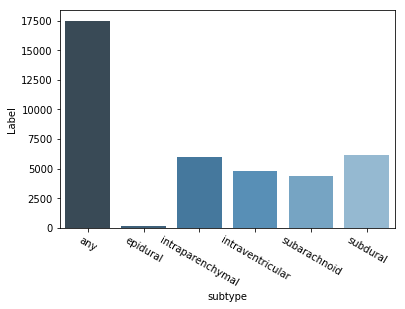

In [28]:
result_csv_data = pd.read_csv('/kaggle/working/final_results.csv')
result_csv_data['img_file'] = result_csv_data['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
result_csv_data['subtype'] = result_csv_data['ID'].apply(lambda st: st.split('_')[2])
groupSub = result_csv_data.groupby('subtype').sum()
label_subtype_plot = sns.barplot(y=groupSub.Label, x=groupSub.index, palette="Blues_d")

for item in label_subtype_plot.get_xticklabels():
    item.set_rotation(-30)

In [29]:
result_df = pd.read_csv('/kaggle/working/final_results.csv')

COLUMNS = ['Patient ID', 'Hemorrhage Subtype', 'Probability']

final_df = pd.DataFrame()

final_df['Patient ID'] = result_df['ID'].apply(lambda st: "ID_" + st.split('_')[1])
final_df['Hemorrhage Subtype'] = result_df['ID'].apply(lambda st: st.split('_')[2])
final_df['Probability'] = result_df['Label']

final_df = final_df[~final_df['Hemorrhage Subtype'].str.contains('any', na=False)]
final_df

,Patient ID,Hemorrhage Subtype,Probability
121232,ID_0fbf6a978,epidural,0.002313
121233,ID_d62ec3412,epidural,0.002313
121234,ID_cb544194b,epidural,0.002313
121235,ID_0d62513ec,epidural,0.002313
121236,ID_fc45b2151,epidural,0.002313
...,...,...,...
727387,ID_50758faa7,subdural,0.006411
727388,ID_2431b61ac,subdural,0.006411
727389,ID_f6152412b,subdural,0.006411
727390,ID_fb3ecd81b,subdural,0.013944


In [30]:
unique_values = final_df['Patient ID'].unique()
unique_values = unique_values.tolist()

all_values = []

for i in unique_values:
    pid_value = final_df[final_df['Patient ID'] == i]
    pid_value = pid_value[pid_value.Probability == pid_value.Probability.max()]
    test = pid_value.values.tolist()
    all_values.append(test[0])
    
final_results_df = pd.DataFrame(all_values, columns = ['Patient ID', 'Hemorrhage Subtype', 'Probability'])
final_results_df

,Patient ID,Hemorrhage Subtype,Probability
0,ID_0fbf6a978,intraventricular,0.109309
1,ID_d62ec3412,intraventricular,0.109309
2,ID_cb544194b,intraventricular,0.109309
3,ID_0d62513ec,intraventricular,0.109309
4,ID_fc45b2151,intraventricular,0.109309
...,...,...,...
121227,ID_50758faa7,subarachnoid,0.008360
121228,ID_2431b61ac,subarachnoid,0.008360
121229,ID_f6152412b,subarachnoid,0.008360
121230,ID_fb3ecd81b,subdural,0.013944


In [31]:
final_results_df[['Patient ID', 'Hemorrhage Subtype', 'Probability']].to_csv('analysis_final_results.csv', index=False)